In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv
import scipy.integrate
from iminuit import Minuit
import random

Q1. Determining the statistical precision of each parameter measurement. It is assumed that there is perfect detector resolution and perfect time measurements.

To solve this I implement the Monte Carlo box method to generate decay times in the decay_times function. After normalising the decay distribution to get the PDF, I calculate the negative log likelihood which is then passed into the Minuit minimiser which fits for the three parameters Tau, V and delta_m to estimate the parameters. This experiment is repeated 500 times, and the best parameters are plotted in a Histogram which results in three Gaussian distributions, one for each parameter. The standard deviations of these distribuutions are taken as the statistical precision with which you can measure each parameter. 



In [2]:
#Define nominal values of the parameters
tau = 1.5
V = 0.1
delta_m = 20.0

#Function that calcualtes the distribution of muon decays
def decay(x1,V,delta_m,tau):
    return (1 + V*np.sin(delta_m*x1))*np.exp(-x1/tau)

#Function calculates the probability density function by normalising the decay distribution
def tnorm(t,V,delta_m,tau):
    args = (V,delta_m,tau)
    
    #call scipy.quad function to calculate normalisation factor. Integrate over interval [0,10] because the probability of decay
    #after 10 seconds is low.
    integ = scipy.integrate.quad(decay,0,10,args = args,limit=200)          
    return (1/integ[0])*(1 + V*np.sin(delta_m*t))*np.exp(-t/tau)

#Use Monte-Carlo simulation box method to generate decay times 
def decay_times(tau,V,delta_m,nevents ):  
    count =0                                   #Counter to track how many decay times have been generated
    t = []                                     #Empty list to store decay times
    #Define max which is at least greater than the maximum of the function in the interval
    fmax =1.1                                  #Chosen 1.1 since this is greater than max val as can be seen from plot below.                         
    tmin = 0                                   #Interval to generate decay times between 
    #Interval max set to 10 because the probaability of decay after this is very small. My explanation for this is at the end 
    #of the notebook.
    tmax = 10
    
    
    #Loop until nevents decay events have been generated
    while count < nevents:
        x1=np.random.uniform(0,1)  
        x1 = tmin +(tmax-tmin)*x1              #Convert random float to interval [tmin,tmax]
   
        y1 = decay(x1,V,delta_m,tau)           #Get the time value's corresponding y value from decay distribution
        y2 = np.random.uniform(0,1) 
        y2 = fmax*y2                           #convert randomly generated y value to interval [0,fmax]  (unnecessary when fmax =1)    
        
        if y2 < y1:
            count += 1                         
            t.append(x1)                    
             
         

    return t
            
 


1.0503384689289477


Text(0, 0.5, 'decay function f(x)')

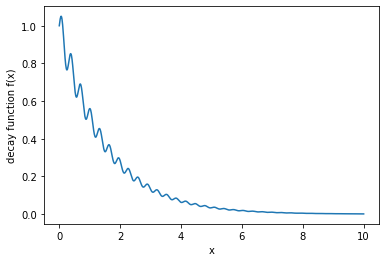

In [3]:
#Determining appropriate fmax in decay_times function
#Plot the function to determine the maximum of the function in the interval [0,10].
xvals = np.linspace(0,10,1000)
yvals = (1 + V*np.sin(delta_m*xvals))*np.exp(-xvals/tau)
print(np.max(yvals))
plt.plot(xvals,yvals) 
plt.xlabel('x')
plt.ylabel('decay function f(x)')

From this plot it seems clear that we must set fmax to slightly above 1. I have chosen 1.1. 

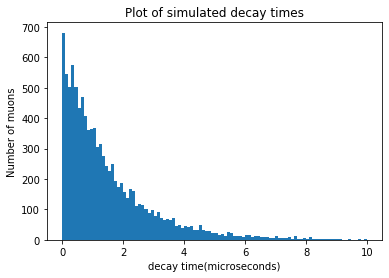

In [4]:

#Plot decay distribution with nominal values
t = decay_times(tau = 1.5,V = 0.1, delta_m = 20.0,nevents = 10000)

nbins = 100

plt.hist(t, bins = nbins,density = False)
plt.title('Plot of simulated decay times')
plt.ylabel('Number of muons')
plt.xlabel('decay time(microseconds)')
plt.show()


In [9]:
def run_minim(min_func):
    params = ['tau','V','delta_m']                        #set parameters to be calculated

    #Setting values to start at and estimated errors. 
    startvals = {params[0] : 1.5,params[1] : 0.1, params[2] : 20.0}      
    
    theMinuit = Minuit(min_func, **startvals)               #run Minuit optimiser  with NLL function.
    theMinuit.errors=[0.1,0.1,0.1]                          #Errors on initial start value
    #theMinuit.limits['delta_m']=(19,21)
    #theMinuit.limits['V'] = (0,0.2)
    #Nll increases by 0.5 when you go to either side of the minimum by one unit error on the parameter
    theMinuit.errordef=0.5    
    
    
    #Set errordef to 0.5 since this a log-likelihood function
    #Run the minimisation
    result = theMinuit.migrad()
    return params, theMinuit

In [10]:
t = np.array(decay_times(1.5,0.1,20.0,nevents =10000))      #Generate decay times

#Function to calculate negative log likelihood of pdf
def NLLpdf(tau,V,delta_m):
    
    t_normed = tnorm(t,V,delta_m,tau)                 #Call function to caluclate pdf
    t_normed[t_normed<=0] = 1*10**(-15)               #Set 0 and negative values to a small postive number or will have zero division
 
    return -np.sum(np.log(t_normed))                  #Return negative log likelyhood    

In [11]:
def run_exps(nevents):
    iterations= 500                                                   #Define number of experiments to run

    #Create empty arrays to store estimated parameters for each experiment
    tau_vec = np.zeros(iterations) 
    V_vec = np.zeros(iterations)
    delta_m_vec = np.zeros(iterations)

    #iterate through experiments finding the best fit parameters for each and storing them in their corresponding arrays
    for i in range(iterations):
        global t
        t = np.array(decay_times(1.5,0.1,20.0,nevents = 10000))       #Generate new set of decay times in each experiment
        params,theMinuit = run_minim(NLLpdf)                          #Call minimiser
        tau_vec[i]= (theMinuit.values[0])
        V_vec[i]=(theMinuit.values[1])
        delta_m_vec[i]=(theMinuit.values[2])
        #print(i, end=" ")                                            #Display current iteration

    #For each of the three parameters calculate the mean fitted parameter over the 500 experiments
    tau_vec_mean = np.mean(tau_vec)
    V_vec_mean = np.mean(V_vec)
    delta_m_vec_mean = np.mean(delta_m_vec)
    tau_vec_std = np.std(tau_vec)
    V_vec_std = np.std(V_vec)
    delta_m_vec_std = np.std(delta_m_vec)
    print(' ')

    print('Calculated mean tau, V and delta_m with statistical precision:')
    print('\t','{:15s}'.format('Tau'), ':  \t', "{0:8.4f}".format(tau_vec_mean), ' +/- ', "{0:8.4f}".format(tau_vec_std))
    print('\t','{:15s}'.format('V'), ':  \t', "{0:8.4f}".format(V_vec_mean), ' +/- ', "{0:8.4f}".format(V_vec_std))
    print('\t','{:15s}'.format('delta_m'), ':  \t', "{0:8.4f}".format(delta_m_vec_mean), ' +/- ', "{0:8.4f}".format(delta_m_vec_std))


   
    nbins = 100                   
    plt.hist(tau_vec, bins = nbins,density = True)
    plt.axvline(tau_vec_mean, color='r', linewidth=1,label = "Mean Tau")
    plt.axvline(tau_vec_mean+ tau_vec_std, color='k', linestyle='dashed', linewidth=1, label="1 sigma deviation")
    plt.title('Distribution of lifetimes')
    plt.xlabel('estimated lifetimes')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()

    plt.hist(V_vec, bins = nbins,density = True)
    plt.axvline(V_vec_mean, color='r', linewidth=1, label = "Mean V")
    plt.axvline(V_vec_mean+V_vec_std, color='k', linestyle='dashed', linewidth=1,label="1 sigma deviation")
    plt.title('Distribution of V')
    plt.xlabel('estimated V')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()

    plt.hist(delta_m_vec, bins = nbins,density = True)
    plt.axvline(delta_m_vec_mean, color='r', linewidth=1,label="Mean delta_m")
    plt.axvline(delta_m_vec_mean+delta_m_vec_std, color='k', linestyle='dashed', linewidth=1,label="1 sigma deviation")

    plt.title('Distribution of delta_m')
    plt.xlabel('estimated delta_m')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()
    return V_vec_mean,delta_m_vec_mean,tau_vec_mean, tau_vec_std,delta_m_vec_std,V_vec_std
    


 
Calculated mean tau, V and delta_m with statistical precision:
	 Tau             :  	   1.5005  +/-    0.0153
	 V               :  	   0.0995  +/-    0.0139
	 delta_m         :  	  20.0004  +/-    0.0774


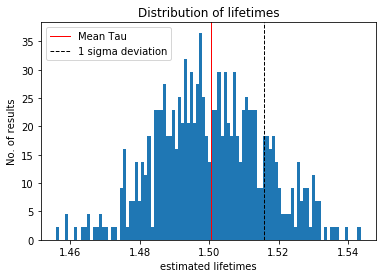

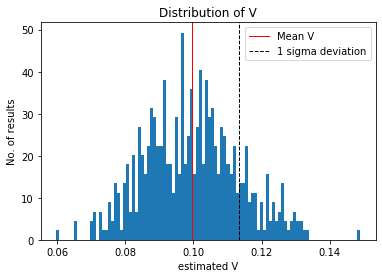

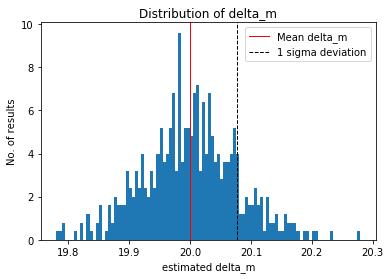

In [12]:
V_vec_mean,delta_m_vec_mean,tau_vec_mean, tau_vec_std,delta_m_vec_std,V_vec_std =run_exps(nevents = 10000)

Here I have plotted the histograms for the Tau, V and delta_m values. The mean values are calculated from averaging the best fit parameters over the 500 experiments and they  are signified by the vertical red lines. The statistical precision (1 sigma away from the mean)  for each parameter is signified by the dashed black lines. There is a 68.3% chance of finding best fit parameters within this statistical precision from the mean values.  We can observe that the three mean best fitted parameters are all within their respective statistical precision from the nominal values

With more experiments, I would expect the mean values to converge to the nominal values, so at the limit of infinite experiments I would expect to see the mean estimates equal to the nominal values.


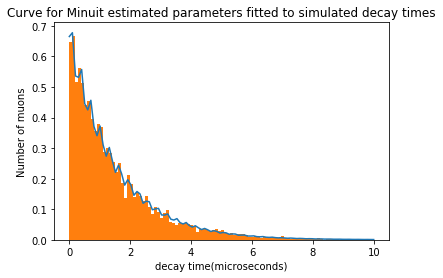

In [13]:
#Fit line to the decay distribution using the best fit parameters
x = np.linspace(0,10,100)    
fit = tnorm(x,V_vec_mean,delta_m_vec_mean,tau_vec_mean)        #generate values of fit line using estimated parameters
plt.plot(x,fit)
plt.hist(t, bins = nbins,density = True)
plt.title('Curve for Minuit estimated parameters fitted to simulated decay times')
plt.ylabel('Number of muons')
plt.xlabel('decay time(microseconds)')
plt.show()



We can observe that the fitted curve approximately follows the simulated decay times with the oscillations in the curve aligning with the spikes in the decay times counts.

 
Calculated mean tau, V and delta_m with statistical precision:
	 Tau             :  	   1.4997  +/-    0.0150
	 V               :  	   0.1019  +/-    0.0142
	 delta_m         :  	  19.9990  +/-    0.0709


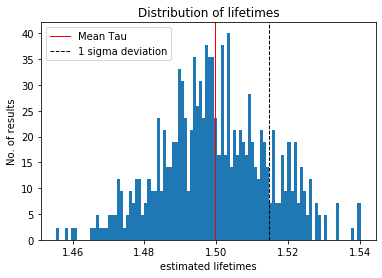

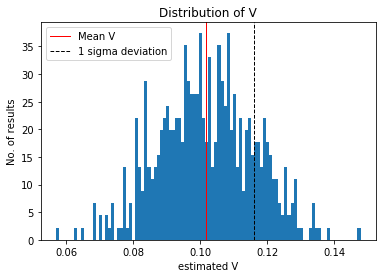

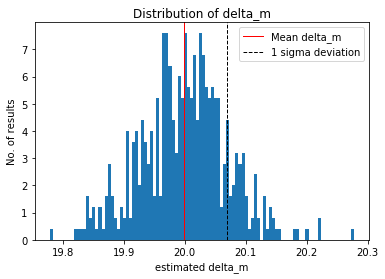

In [14]:
#Run 500 experiments using 100,000 decay events in each experiment
V_vec_mean,delta_m_vec_mean,tau_vec_mean,tau_vec_std2,delta_m_vec_std2,V_vec_std2 =run_exps(nevents = 100000)

Here I have plotted histograms for the 500 experiments run with 100,000 events. We see that the precision is very slightly greater than when we ran the Monte Carlo toy experiments with only 10,000 events. This aligns with what we would expect. As you increase events you are going to get an tighter precision on average Tau values calculated in each indiviual experiment. Therefore, the spread of Tau values will also be less varying as a result for the 500 experiments run with 100,000 events versus running 500 experiments with 100,000 events.

Q2. We now must determine the bias introduced to the measurement of each parameter when the data is subject to the resolution effect. To account for this effect, I define a new function for generating decay times with the box method. This function takes in a parameter f which is proportional to the standard deviation of the resolution. I then draw a value from a Gaussian centred around 0 with a standard deviation of f*tau and add this value to the simulated decay time. With these newly generated decay times, now with a random error introduced by the measurement, I repeat the minimisation from the previous question in order to fit the three parameters. By comparing the newly fitted parameters with the nominal values I can determine the bias introduced by the resolution effect.

In [15]:


#Define a new function which draws time value from a Gaussian with mean = tau and sigma = tau * f rather than a uniform distribution 
def decay_times_resolution(tau,V,delta_m,f):  
    count =0                                   #Counter to track how many decay times have been generated
    t = []                                     #Empty list to store decay times
    #Define max which is at least greater than the maximum of the function in the interval
    fmax =1.1                                  #Chosen 1.1 since this is greater than max val as can be seen from plot below.                         
    tmin = 0                                   #Interval to generate decay times between 
    tmax = 10                                  #Interval max set to 10 because the probaability of decay after this is very small
   
   
    nevents = 10000                            #Define number of events
    
  
    
    #Box method 
    while count < nevents:
        t_res = np.random.normal(0, f*tau)                #draw value from gaussian mean = 0, sigma = f * tau. This is the resolution
        x1=np.random.uniform(0,1) 
        x1 = tmin +(tmax-tmin)*x1
   
        y1 = decay(x1,V,delta_m,tau)
        y2 = np.random.uniform(0,1) 
        y2 = fmax*y2
        
        if y2 < y1:
            x1 += t_res                                  #Add the resolution error to the simulated decay time
            count += 1
            t.append(x1)
             
         

    return t
            
 

                                                           
  

In [16]:
#This functions similar to the previous time_estimator function. The difference is that this function takes a parameter f which
# which is used to sclae the standard deviation of the Guassian that each time decay is drawn from.
def time_res_estimator(f):
    iterations= 500                                           #Define number of experiments
    
    #Create empty arrays to store fitted parameters from each experiment
    tau_vec = np.zeros(iterations)
    V_vec = np.zeros(iterations)
    delta_m_vec = np.zeros(iterations)

    #iterate through experiments finding the best fit parameters for each and storing them in their corresponding arrays
    for i in range(iterations):
        global t
        t= np.array(decay_times_resolution(1.5,0.1,20.0,f))       #Generate decay times with added resolution error
        params,theMinuit = run_minim(NLLpdf)                      #Call minimiser function
        tau_vec[i]= (theMinuit.values[0])
        V_vec[i]=(theMinuit.values[1])
        delta_m_vec[i]=(theMinuit.values[2])
        # print(i, end=" ")
        
    tau_vec_mean = np.mean(tau_vec)
    V_vec_mean = np.mean(V_vec)
    delta_m_vec_mean = np.mean(delta_m_vec)
    
    #Calculate bias introduced by resolution error
    tau_bias = (tau_vec_mean-tau) 
    V_bias = ( V_vec_mean-V) 
    delta_m_bias = (delta_m_vec_mean-delta_m) 
    print(' The bias introduced from the resolution effect:')
    print('bias on the mean: ',"{0:8.4f}".format(tau_bias))
    print('bias on the V: ',"{0:8.4f}".format(V_bias))
    print('bias on the delta_m: ',"{0:8.4f}".format(delta_m_bias))

    #print("Average of average lifetimes is {:.4g} microseconds".format(mean))
    nbins = 30
    plt.hist(tau_vec, bins = nbins)
    
    plt.axvline(tau_vec_mean, color='r', linewidth=1, label="Fitted tau mean")
    plt.axvline(tau, color='g', linewidth=1, label = "Nominal tau ")
    plt.title('Distribution of lifetimes')
    plt.xlabel('estimated lifetimes')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()

    plt.hist(V_vec, bins = nbins)
    plt.axvline(V_vec_mean, color='r', linewidth=1,label = "fitted V mean")
    plt.axvline(V, color='g', linewidth=1, label = "Nominal V")
    plt.title('Distribution of V')
    plt.xlabel('estimated V')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()

    plt.hist(delta_m_vec, bins = nbins)
    plt.axvline(delta_m_vec_mean, color='r', linewidth=1, label = "Fitted delta_m mean")
    plt.axvline(delta_m, color='g', linewidth=1, label = "Nominal delta_m")
    plt.title('Distribution of delta_m')
    plt.xlabel('estimated delta_m')
    plt.ylabel('No. of results')
    plt.legend()
    plt.show()
    return tau_vec_mean, V_vec_mean, delta_m_vec_mean
    


 The bias introduced from the resolution effect:
bias on the mean:   -0.0006
bias on the V:   -0.0056
bias on the delta_m:    0.0003


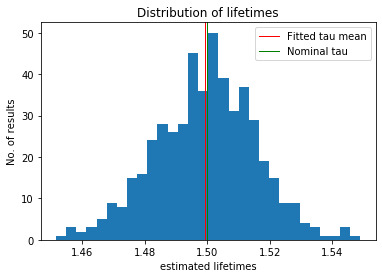

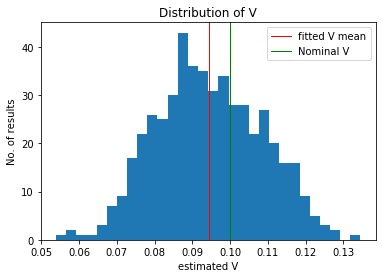

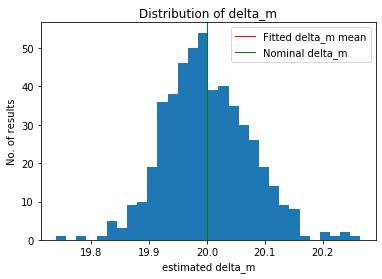

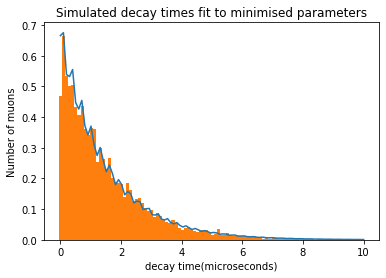

In [17]:
tau_vec_mean, V_vec_mean, delta_m_vec_mean = time_res_estimator(f=0.01) #call function to run 500 experiments with f = 0.1 
fit = tnorm(x,V_vec_mean,delta_m_vec_mean,tau_vec_mean)
plt.plot(x,fit)
plt.hist(t, bins = nbins,density = True)
plt.title('Simulated decay times fit to minimised parameters')
plt.ylabel('Number of muons')
plt.xlabel('decay time(microseconds)')
plt.show()
   



There is very little bias introduced on to the measurement of the mean decay lifetime. Only 0.0006 bias which is significantly less than the expected statistical precision calculated in part 1 which was 0.0153. If we were to add the errors in quadrature to get the total error, the result would be 0.0153 to 3 significant figures which is equal to the statistical presion alone. Thus, we can conclude that this bias on the lifetime is negligble.

On the other hand there is seemingly non-negligble negative bias introduced on to the measurement of the mean V value. The bias calculated for V was -0.0056 which is less than the expected statistical precision of 0.014. The total error calculated by adding the errors in quadrature gives 0.015 to 2 significant figures. Therefore the bias does have an effect of introducing additional error. 

The bias on delta_m, -0.0003, is low similar to the bias on tau. The expected statistical precision of the delta_m measurement,0.0774, so the bias is comparatively less significant. Again calculating the total error gives  0.0774 to 3 significant figures which is equal to the statistical presion.Thus, we can conclude that this bias on delta_m is negligble.

 The bias introduced from the resolution effect:
bias on the mean:   -0.0037
bias on the V:   -0.0541
bias on the delta_m:   -0.0176


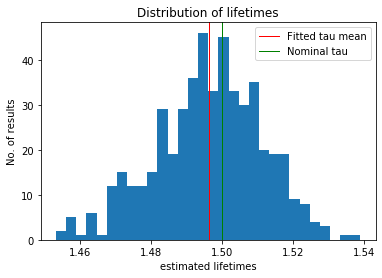

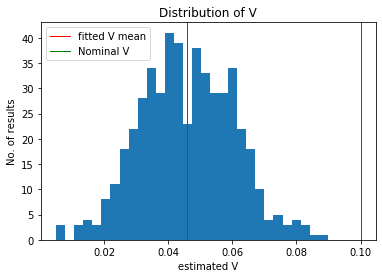

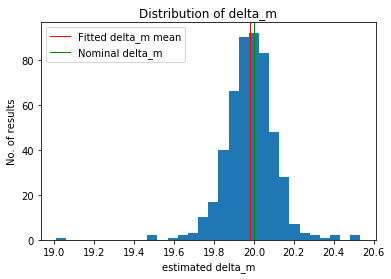

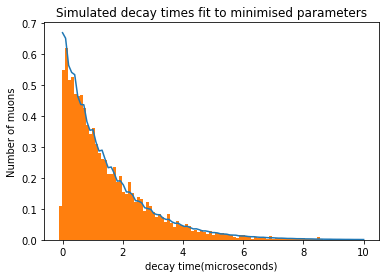

In [18]:

tau_vec_mean, V_vec_mean, delta_m_vec_mean = time_res_estimator(f=0.03)    #call function to run 500 experiments with f = 0.03
fit = tnorm(x,V_vec_mean,delta_m_vec_mean,tau_vec_mean)
plt.plot(x,fit)
plt.hist(t, bins = nbins,density = True)
plt.title('Simulated decay times fit to minimised parameters')
plt.ylabel('Number of muons')
plt.xlabel('decay time(microseconds)')
plt.show()

Repeating the above with a larger fraction f = 0.03 reinforces the previous findings but the biases are slightly more extreme which is expected since we are using a larger standard deviation in the resolution. The bias on tau is now -0.0037 which is still less significant than the statistical error of 0.0153. The total error is 0.0157. This is only very slightly more than the statistical error so the bias does not effect the mean lifetime significantly.

The bias on V that was significant for f = 0.01 is now even more significant; the bias on V for f=0.03 is -0.0541 which is approximately half the nominal value of V. The statistical preicison is 0.014 so the negative bias is in fact much larger than the statistical precision. 

Finally the bias on delta_m is -0.0176 which is lower in magnitude than the statistical precision which is 0.0774. The total error is 0.0794. Therefore the bias here is not negligible, but it only has a small contribution to the total error.



Q3. In this last section we look at the systematic error due to time acceptance where a(t) = 1+st) and s is known to a precision s = 0+/- 0.03. In order to isolate systematic error from random error, we want to perform multiple fits to the same set of data. To do this, I first generate decay times using the decay_times function to generate a single set of decay time. Then 100 s values are drawn from a Gaussian distribution with mean 0 and standard deviation 0.03. The s values are then iterated over, and in each iteration the s value is used in the fitting of the decay time distribution. The systematic error due to time acceptance can then be estimated by taking the standard deviation of the fitted parameter distribution for each parameter. 

In [19]:
#Define new NLL function to calculate negative log likelihood of normalised 
#decay multiplied by the acceptance function
def NLLpdf_acceptance(tau,V,delta_m):
    
    t_normed = tnorm_acc(t,V,delta_m,tau) 
    t_normed[t_normed<=0] = 1*10**(-15)    #Set values below or equal to 0 to a low value to avoid divide by zero
 
    return -np.sum(np.log(t_normed))                

In [20]:
#Define new decay function with acceptance function multiplied by the original decay function
def decay_acc(x1,V,delta_m,tau):
    return (1 + V*np.sin(delta_m*x1))*np.exp(-x1/tau)*(1+s*x1)

#Function that returns normals decay*time_acceptance function
def tnorm_acc(t,V,delta_m,tau):
    args = (V,delta_m,tau)
    integ = scipy.integrate.quad(decay_acc,0,10,args = args) 
    return (1/integ[0])*(1 + V*np.sin(delta_m*t))*np.exp(-t/tau)*(1+s*t)


In [73]:
#Generate a single set of decay times, 10,000 events.
t= np.array(decay_times(1.5,0.1,20.0,nevents = 10000))

#Define new function that calls minuit minimiser and returs the estimated parameters
def time_estimator_acceptance(s):

    params,theMinuit = run_minim(NLLpdf_acceptance)
    tau_acc = theMinuit.values[0]
    V_acc = theMinuit.values[1]
    delta_m_acc = theMinuit.values[2]
    return tau_acc,V_acc,delta_m_acc

    

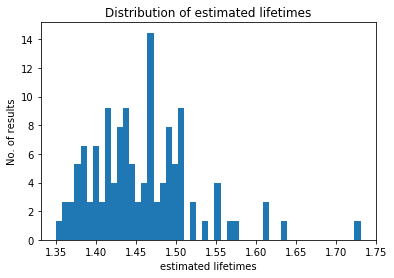

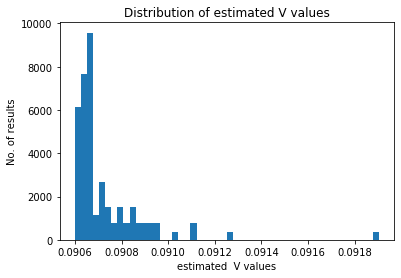

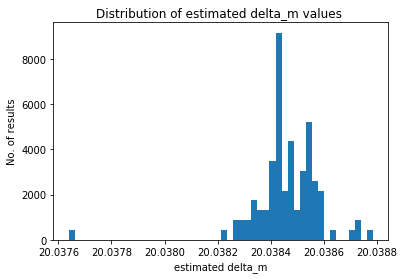

In [74]:
#Draw 100 s values from a Gaussian distribution with mean = 0, std = 0.03
s_array = np.random.normal(0,0.03,100)
tau_acc_vec = []
V_acc_vec = []
delta_m_acc_vec = []

#Iterate through array of s values and fit to data using time acceptance fit. 
#Append the estimated parameters with the different fits on the same data.
for i in range(len(s_array)):
    global s
    s = s_array[i]
    tau_acc, V_acc, delta_m_acc = time_estimator_acceptance(s) 
    tau_acc_vec.append(tau_acc)
    V_acc_vec.append(V_acc)
    delta_m_acc_vec.append(delta_m_acc)

    
nbins = 50
plt.hist(tau_acc_vec, bins = nbins,density = True)
plt.title('Distribution of estimated lifetimes')
plt.xlabel('estimated lifetimes')
plt.ylabel('No. of results')    
plt.show()

plt.hist(V_acc_vec, bins = nbins,density = True)
plt.title('Distribution of estimated V values')
plt.xlabel('estimated  V values')
plt.ylabel('No. of results')    
plt.show()

plt.hist(delta_m_acc_vec, bins = nbins,density = True)
plt.ticklabel_format(useOffset=False)
plt.title('Distribution of estimated delta_m values ')

plt.xlabel('estimated delta_m')
plt.ylabel('No. of results')    
plt.show()

The standard deviations for the estimated V and delta_m parameters are very small. This is why the distributions don't appear obviously Gaussian because the peaks are relatively tall and outliers exist such as the few estimated delta_m at 20.0376 delta_m. Below I have calculated the systematic errors from the standard deviations, but it is quite evident from the plots  that the standard deviation on lifetime estimations is much greater than on the other two parameters.

In [81]:

systematic_err_tau = np.std(tau_acc_vec)
systematic_err_V = np.std(V_acc_vec)
systematic_err_delta_m = np.std(delta_m_acc_vec)
print("The systematic error on the tau =", "{0:8.3f}".format(systematic_err_tau))
print("The systematic error on V =","{0:8.5f}".format(systematic_err_V))
print("The systematic error on delta_m =","{0:8.5f}".format(systematic_err_delta_m))

The systematic error on the tau =    0.064
The systematic error on V =  0.00017
The systematic error on delta_m =  0.00013


By fitting models with different time acceptance values to the same data, we isolate the systematic error because the statistal error is constant for that one set of decay times. 

The systematic error on the the estimated tau is 0.064 which is significantly larger to the statistical precision predicted in part 1 of 0.0157. Combining the errors we get a total error of 0.066. This demonstrates that the systematic error contributes heavily to the total error and the stastical precision becomes very insignicant. 

The systematic error on the estimated V is 0.00017 which is less than the statistical precision calculated in part 1 of 0.014. The total error  is 0.014 to two significant figures. So the systematic error is negligble.  The systematic error on delta_m is 0.00013 which again is lower than the predicted statistical precision 0.0774. Again the total error is equal to the predicted statistical precision to three significant figures implying that the systematic error is negligible. 

We can conclude that the systematic error introduced by the time acceptance function only impacts the estimation of the lifetime, tau, significantly. This aligns with what we would expect the time acceptance because it is an equal shift in the decay times recorded which will only effect the lifetime estimation.

Note: Below is my reasoning for limiting the decay to an interval between 0 and 10 seconds in all three tasks.

In [84]:

#Use Monte-Carlo simulation box method to generate decay times 
def decay_times_check(tau,V,delta_m,nevents ):  
    count =0                                   #Counter to track how many decay times have been generated
    t = []                                     #Empty list to store decay times
    #Define max which is at least greater than the maximum of the function in the interval
    fmax =1.1                                  #Chosen 1.1 since this is greater than max val as can be seen from plot below.                         
    tmin = 0                                   #Interval to generate decay times between 
    tmax = 100                                  #Interval max set to 10 because the probaability of decay after this is very small
   
    
    
    #Loop until nevents decay events have been generated
    while count < nevents:
        x1=np.random.uniform(0,1)  
        x1 = tmin +(tmax-tmin)*x1              #Convert random float to interval [tmin,tmax]
   
        y1 = decay(x1,V,delta_m,tau)           #Get the time value's corresponding y value from decay distribution
        y2 = np.random.uniform(0,1) 
        y2 = fmax*y2                           #convert randomly generated y value to interval [0,fmax]  (unnecessary when fmax =1)    
        
        if y2 < y1:
            count += 1                         
            t.append(x1)                    
             
         

    return t
            
 


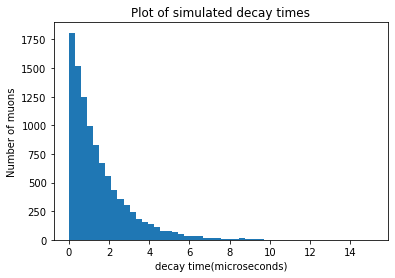

In [86]:

#Plot decay distribution with nominal values
t_check = decay_times_check(tau = 1.5,V = 0.1, delta_m = 20.0,nevents = 10000)

plt.hist(t_check, bins = nbins,density = False)
plt.title('Plot of simulated decay times')
plt.ylabel('Number of muons')
plt.xlabel('decay time(microseconds)')
plt.show()


In [91]:
t_check = np.array(t_check)
ratio = 100*(len(t_check[t_check>10])/len(t_check))
print("The % of decays after 10 seconds","{0:8.3f}".format(ratio))

The % of decays after 10 seconds    0.070


Hence I chose to limit to 10 seconds since the function quickly decays and the number of decay times after 10 seconds is very small compared to the number of decay times <= 10 seconds.
